In [2]:
import pandas as pd
import re
from tqdm import tqdm
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
from nltk import word_tokenize
from nltk.corpus import stopwords

df_path = r'C:\Users\natti\OneDrive\Desktop\DS\DL\Assignment\Data pre-processing\data_tweet_sample_challenge.csv'
df = pd.read_csv(df_path)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# -------------- Data Pre-Processing - Translation Task -----------------------

from googletrans import Translator # pip install googletrans==4.0.0-rc1

# Initailise translation
translator = Translator()

# Define a function to translate other languages to English 
def translate_to_english(text, language):
    # Perform translation if the language is not in english
    if language != 'en':
        try:
            translation = translator.translate(text, src=language, dest='en')
            return translation.text
        except Exception as e:
            # in case of error, return original text
            return text
    # else, return the original english text as-is
    else:
        return text

# Use tqdm to display a progress bar
tqdm.pandas()

# Apply translate function to non-English tweets
df['text'] = df.progress_apply(lambda row: translate_to_english(row['text'], row['label']), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:19<00:00,  9.39it/s]


In [4]:
# ---------------Data Pre-Processing - Data Cleaning --------------------------

# Load list of English stop words
stop = stopwords.words('english')
stop.append('rt')  # Retweet


# Define a function for data cleaning 
def cleaning(text):
    text = text.lower()
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text = re.sub(r'\bgt\s+gt\b', '', text)
    text = " ".join([word for word in text.split() if word not in (stop)])
    return text

# Apply def cleaning function to "text" column with tqdm
tqdm.pandas()
df['text'] = df['text'].progress_apply(cleaning)

df.to_csv("translation.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 7863.43it/s]


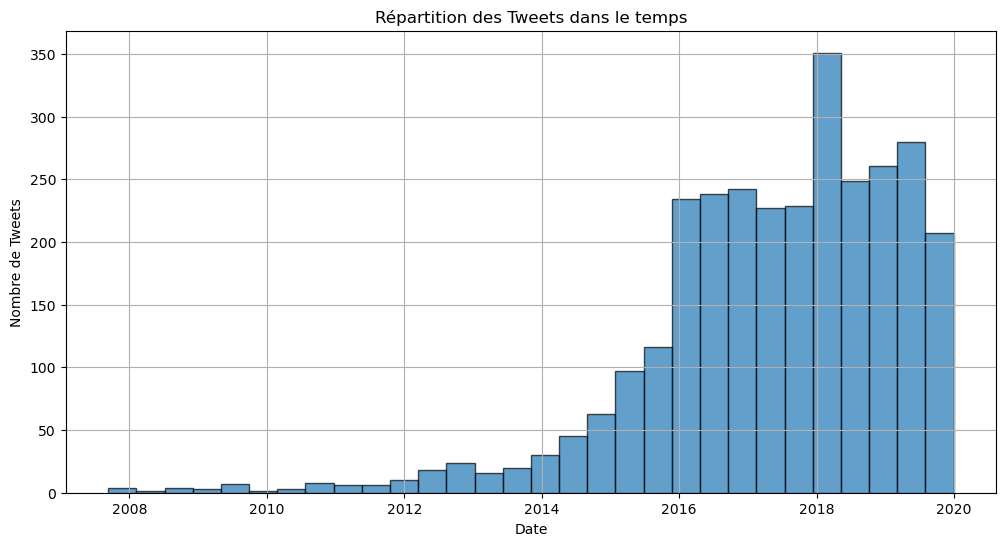

In [5]:
#---------------------------------Data Exploration-----------------------------

## Visualisation des Tweets dans le temps ##
# Dans cette section, nous allons visualiser la distribution des tweets dans le temps
import matplotlib.pyplot as plt


# On convertit la colonne 'created_at' en datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# On plot l'histogramme
plt.figure(figsize=(12, 6))
df['created_at'].hist(bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Nombre de Tweets')
plt.title('Répartition des Tweets dans le temps')
plt.show()


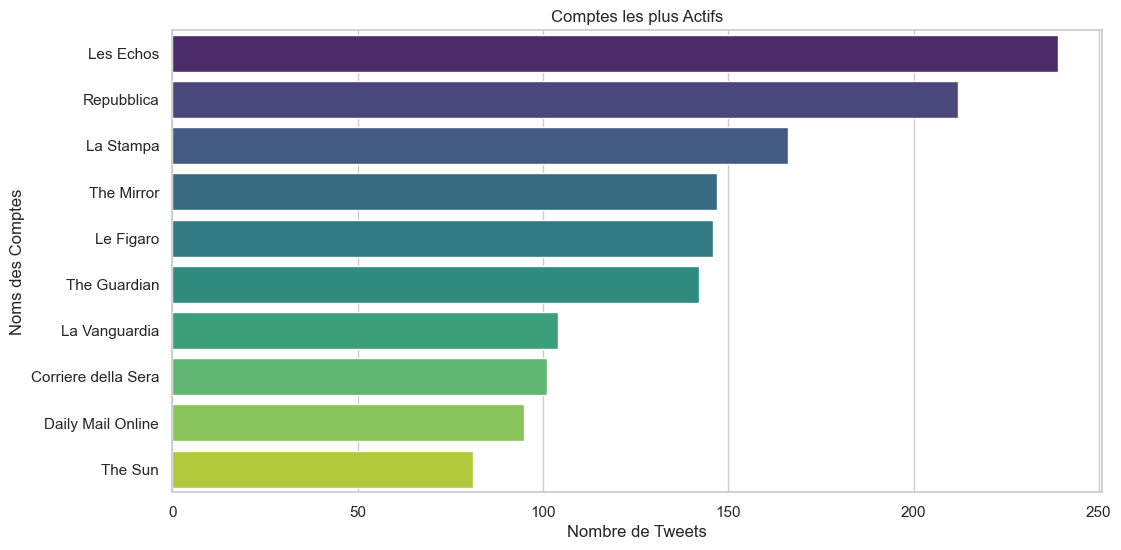

In [6]:
## Les comptes le plus actifs ##
# Dans cette section, nous comptons les occurrences des comptes les plus actifs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

account_counts = df['author.name'].value_counts()

# On sélectionne les 10 comptes les plus actifs
top_accounts = account_counts.head(10)

# On onfigure le style seaborn pour un graphique plus joli
sns.set(style="whitegrid")

# On plot un graphique à barres avec seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=top_accounts.values, y=top_accounts.index, palette="viridis")
plt.xlabel('Nombre de Tweets')
plt.ylabel('Noms des Comptes')
plt.title('Comptes les plus Actifs')
plt.show()

In [7]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [8]:
import transformers
print(transformers.__version__)

2.1.1


In [11]:
#-------------------------Name Entity Recognition------------------------------

## Extraction des entités clés ##
# Dans cette section, nous extrayons des entités clés des tweets

from transformers import pipeline

ner = pipeline("ner", grouped_entities=True)

# Fonction pour appliquer la NER à un tweet et renvoyer les entités
def apply_ner(tweet):
    entities = ner(tweet)
    return entities

tqdm.pandas()
# Appliquez la NER à chaque tweet et stockez les entités dans une nouvelle colonne
df['key_entities'] = df['text'].progress_apply(apply_ner)

# Pour voir la 8e ligne
df['key_entities'].iloc[7]

ImportError: cannot import name 'pipeline' from 'transformers' (C:\Users\natti\anaconda3\Lib\site-packages\transformers\__init__.py)

In [12]:
## La fréquence des entités clés ##
# Dans cette section, nous analysons la fréquence des entités clés extraites des tweets pour voir celles qui sont les plus cités

import json
from collections import Counter

# On extrait des entités à partir des chaînes JSON
entities_list = []
for entity_json_list in df['key_entities']:
    for entity_json in entity_json_list:
        entity_word = entity_json['word']
        entities_list.append(entity_word)

entity_counts = Counter(entities_list)
sorted_entities = entity_counts.most_common()

# On stocke les entités les plus fréquentes dans les sujets clés
sujets_cles = sorted_entities[:10]

# Affichez les sujets clés
for entite, compteur in sujets_cles:
    print(f"Entité : {entite}, Fréquence : {compteur}")
    

KeyError: 'key_entities'

In [ ]:
#------------------------Sentiment Analysis------------------------------------

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Define the function to analyze the sentiment of a tweet
def analyze_sentiment(text):
  # Tokenize the tweet
  inputs = tokenizer(text, return_tensors="pt")
  # Make a prediction
  outputs = model(**inputs)
  # Get the predicted sentiment (0, 1, or 2)
  sentiment = outputs.logits.argmax().item()
  
  # Map numerical sentiment to words
  sentiment_mapping = {0: "négative", 1: "positive", 2: "neutre"}
  sentiment_word = sentiment_mapping[sentiment]
  
  # Return the sentiment
  return sentiment_word

# Use tqdm to display a progress bar
tqdm.pandas()
# Apply the sentiment analysis function to the dataset of tweets
df["sentiment"] = df["text"].apply(analyze_sentiment)

# Count the number of tweets for each sentiment
sentiment_counts = df["sentiment"].value_counts()

# Define colors for each segment of the pie chart
colors = ['#ff9999', '#66b3ff', '#99ff99']

# Create a pie chart
plt.figure(figsize=(8, 10))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'white'})
plt.title("Distribution of Sentiments in Tweets", fontsize=16)

# Add a legend
legend_labels = ['Negative', 'Positive', 'Neutral']
plt.legend(legend_labels, title="Sentiments", loc="upper right")

# Show the pie chart
plt.axis('equal')
plt.show()

In [13]:
#Distribution of variables by Sentiments in Tweets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the 'created_at' column to a datetime type
df['created_at'] = pd.to_datetime(df['created_at'])

# Create a custom color palette
palette = {"positive": "green", "négative": "red"}

# Box plot for each numeric variable by sentiment
variables = ["public_metrics.like_count", "public_metrics.retweet_count", "created_at", "author.id", "label"]

for variable in variables:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="sentiment", y=variable, data=df, palette=palette)
    plt.title(f"Distribution of '{variable}' by Sentiment")
    plt.show()
#The result is a series of box plots, one for each variable in the variables list, 

ValueError: Could not interpret input 'sentiment'

<Figure size 1000x600 with 0 Axes>

In [ ]:
#showing how the distribution of that variable varies between different sentiments (positive and negative). 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a word cloud for positive tweets
positive_tweets = df[df['sentiment'] == 'positive']['text']
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_tweets))

plt.figure(figsize=(10, 5)) #size of figure
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Sentiment')
plt.show()

import matplotlib.pyplot as plt

# Convert the 'created_at' column to datetime type
df['created_at'] = pd.to_datetime(df['created_at'])

# Create a time trend chart for each sentiment
sentiments = df['sentiment'].unique()
for sentiment in sentiments:
    sentiment_data = df[df['sentiment'] == sentiment]
    plt.plot(sentiment_data['created_at'], sentiment_data.index, label=sentiment)
# ploting
plt.xlabel('Date')
plt.ylabel('Number of Occurrences')
plt.title('Time Trend of Sentiments')
plt.legend()
plt.show()

In [ ]:
#-------------------zero-shot classification-----------------------------------

# Find candidate labels with wordcloud

from wordcloud import WordCloud 

def generate_wordcloud(dataframe, output_filename, mask_image_path, max_words=50):
    # Text to apply
    text = ' '.join(x for x in dataframe['text'].values)
    # Use image of twitter logo (a bird) to form the shape of wordcloud
    bird_mask = np.array(Image.open(mask_image_path))
    
    wordcloud = WordCloud(background_color=None, mode='RGBA', max_words=max_words, mask=bird_mask).generate(text)
    # Save the wordcloud to an image file
    wordcloud.to_file(output_filename)
    
    # Open the saved image and display it
    saved_wordcloud = Image.open(output_filename)
    plt.imshow(saved_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_wordcloud(df, "wordcloud.png", "C:\\Users\\natti\\OneDrive\\Desktop\\DS\\DL\\Assignment\\bird3.png")

In [ ]:
# After analysing wordcloud, the candidate lebels 'revolutionary' and 'threat' are chosen. 
# This is to see how Industry 4.0 / AI is perceived overall and by countries 
# either it is perceived as something that could potentially make the world a better place ('revolutionary') 
# or it is understood as something that could have negative impact ('threat')

#In a way, this is also to see how well-trained zero-shot classification pipeline
# As humans, we are able to make judement of words and categorize word groups that have similar sentiments. 
# For example, 
# positive sentiments (towards AI) = 'revolutionary', 'invention','opportunity', 'discovery'
# Negative sentiments (towards AI) = ' threat', 'damage', 'menacing'     
# Thus, a well-trained transformer should be able to give similar results/trends when gaven such inputs.

# In class, we were discussed about the reult of sentiment analysis when given generic 'positive' or 'negative' sentiments 
# and the overall result is neutral (similar probability for positive and negative sentiments)
# Therefore, if I give the label as 'revolutionary' and 'threat', the result is supposed to follow the same trend. 


In [ ]:
# First, the goal is to see the overall perception of 4th Industry Revolution from tweets

# Load zero-shot classification pipeline 
from transformers import pipeline

def zero_shot_classification_overall(dataframe, candidate_labels):
    # Initialize zero-shot classification model
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
    
    # Concatenate text from the dataframe
    text = ' '.join(x for x in dataframe['text'].values)
    
    # Apply zero-shot classification
    result = classifier(text, candidate_labels)
    
    # Print the results
    for i in range(len(result['labels'])):
        print(f"Label: {result['labels'][i]}, Score: {result['scores'][i]}")

# chosen topics/labels
candidate_labels = ['revolutionary', 'threat']
# Call the function to get overall results
zero_shot_classification_overall(df, candidate_labels)

#[out]
#Label: threat, Score: 0.5141741633415222
#Label: revolutionary, Score: 0.48582589626312256


In [ ]:
# Second, to see the perception of AI by countries

# Extract country names from the column 'author.location' in the dataset
from geopy.geocoders import Nominatim

# Initialize geopy Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")

# Function to get city from location string
def get_city(location):
    location_info = geolocator.geocode(location, exactly_one=True)
    if location_info:
        return location_info.raw.get('display_name').split(",")[0]
    else:
        return None

# Extract cities and fill country names
df['city'] = df['author.location'].apply(lambda x: get_city(x))
df['country'] = df['author.location'].apply(lambda x: x if get_city(x) is None else None)

# Once the function def get_city is performed, there's some remaining rows that aren't properly extracted
# The remaining rows are manually done on Excel, the result is the csv file below: 
df_path = r'C:\Users\natti\OneDrive\Desktop\DS\DL\Assignment\Data pre-processing\translation_location.csv'
df = pd.read_csv(df_path)

In [ ]:
# Load zero-shot classification pipeline 
from transformers import pipeline

def zero_shot_classification_bycountry(df,candidate_labels=['revolutionary', 'threat'], min_data_threshold = 10):

    # Load zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
    
    # Create an empty dictionary to store the results for each country
    country_results = {}
    
    # Iterate through unique countries in the 'author.location' column
    for country in df['author.location'].unique():
        # Filter the DataFrame for the current country
        country_df = df[df['author.location'] == country]
        
        # Convert NaN or float values in 'text' column to empty strings
        country_df['text'] = country_df['text'].astype(str).fillna('')
        
        # Combine the 'text' values for the current country into a single string
        country_text = ' '.join(country_df['text'].values)
        
        # Apply zero-shot classification for the current country
        result = classifier(country_text, candidate_labels)
        
        # Store the results for the current country in the dictionary
        country_results[country] = {
            'revolutionary_score': result['scores'][result['labels'].index('revolutionary')],
            'threat_score': result['scores'][result['labels'].index('threat')]
        }
    # Print the results for each country
    for country, scores in country_results.items():
        print(f"Country: {country}")
        print(f"Revolutionary Score: {scores['revolutionary_score']}")
        print(f"Threat Score: {scores['threat_score']}")
        print("--------------------")
        
    return country_results

# Call the function to get country-wise results
country_results = zero_shot_classification_bycountry(df)